<a href="https://colab.research.google.com/github/Stecklert1/UST--Deep-Learning-2026/blob/main/Deep_Learning_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
path="/content/drive/MyDrive/single_cell.csv"
df=pd.read_csv(path)
df.head()

,Unnamed: 0,Gene1,Gene2,Gene3,Gene4,Gene5,Gene6,Gene7,Gene8,Gene9,...,Gene192,Gene193,Gene194,Gene195,Gene196,Gene197,Gene198,Gene199,Gene200,group
0,Cell1,5.992481,8.637750,9.148508,0.000000,9.749526,NaN,0.000000,4.704148,11.965938,...,1.172069,2.861306,5.676206,7.064524,5.963797,6.387515,5.404645,5.811143,2.250973,Group1
1,Cell2,6.705927,8.459997,NaN,0.000000,9.613102,8.837886,NaN,4.354085,11.835529,...,0.000000,NaN,NaN,NaN,6.281317,6.541257,5.940163,5.120309,1.607604,Group4
2,Cell3,7.630381,NaN,NaN,0.000000,9.486118,8.731500,NaN,NaN,12.026917,...,0.000000,2.729572,NaN,8.092617,6.048260,6.878665,5.550450,5.957771,2.729572,Group4
3,Cell4,7.067631,8.952405,9.636137,2.034341,9.719746,7.529173,0.000000,NaN,12.129077,...,3.039986,2.623069,5.877711,7.349105,NaN,6.471351,6.568682,5.877711,2.846535,Group3
4,Cell5,5.732078,8.842180,NaN,2.192864,10.138186,7.676739,0.777724,4.987332,12.140196,...,NaN,NaN,5.111780,6.785379,5.567958,NaN,5.455013,5.770349,2.747472,Group1


In [10]:
from sklearn.preprocessing import LabelEncoder

# Assuming df is your DataFrame and 'group' is the target column
y = df['group']

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the 'group' labels to numerical form
y_encoded = label_encoder.fit_transform(y)

# Determine the number of unique classes
num_classes = len(label_encoder.classes_)

print(f"Original labels: {y.unique()}")
print(f"Encoded labels (first 5): {y_encoded[:5]}")
print(f"Number of unique classes: {num_classes}")

Original labels: ['Group1' 'Group4' 'Group3' 'Group2']
Encoded labels (first 5): [0 3 3 2 0]
Number of unique classes: 4


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

num_classes = len(label_encoder.classes_)

model = Sequential()
model.add(Input(shape=(X_scaled.shape[1],)))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=2, activation='relu', name='latent'))
model.add(Dense(units=num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 2)              │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,998 (132.80 KB)

 Trainable params: 33,998 (132.80 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [13]:
class SaveEmbedding(tf.keras.callbacks.Callback):
    def __init__(self, X_data, y_labels, output_dir):
        super().__init__()
        self.X_data = X_data
        self.y_labels = y_labels
        self.output_dir = output_dir
        self.latent_model = None # Initialize to None

    def on_train_begin(self, logs=None):
        # Create output directory if it doesn't exist, and clear its contents
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
        else:
            # Clear existing PNG files
            for filename in os.listdir(self.output_dir):
                if filename.endswith('.png'):
                    os.remove(os.path.join(self.output_dir, filename))
        print(f"Output directory '{self.output_dir}' prepared.")

    def on_epoch_end(self, epoch, logs=None):
        # Create a model to extract the latent layer output, only if it hasn't been created yet
        if self.latent_model is None:
            # Use the input tensor of the InputLayer (model.layers[0]) as the input for the latent_model.
            # This directly accesses the symbolic input tensor of the first layer.
            self.latent_model = tf.keras.Model(
                inputs=self.model.layers[0].input,
                outputs=self.model.get_layer('latent').output
            )

        # Extract 2D latent embeddings
        latent_embeddings = self.latent_model.predict(self.X_data, verbose=0) # Added verbose=0 to suppress predict output

        # Create scatter plot
        plt.figure(figsize=(8, 8))
        scatter = plt.scatter(latent_embeddings[:, 0],
                              latent_embeddings[:, 1],
                              c=self.y_labels,
                              cmap='viridis',
                              alpha=0.7)
        plt.title(f'Latent Space Embeddings - Epoch {epoch+1}')
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')
        plt.colorbar(scatter, label='True Class (Encoded)')
        plt.grid(True)

        # Save the plot
        filename = os.path.join(self.output_dir, f'epoch_{epoch+1:03d}.png')
        plt.savefig(filename)
        plt.close() # Close plot to free up memory

In [14]:
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Assuming df is your DataFrame containing 'Gene' columns and a 'group' column
# Separate features (X) and target (y)
X = df.drop(columns=['Unnamed: 0', 'group'])
y = df['group']

# Impute missing values in X
imputer = SimpleImputer(strategy='mean') # Using mean imputation as a common strategy
X_imputed = imputer.fit_transform(X)

# Scale the features
specify_scaler = StandardScaler()
X_scaled = specify_scaler.fit_transform(X_imputed)

# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Now, the original code can proceed
output_directory = 'frames'
save_embedding_callback = SaveEmbedding(X_data=X_scaled, y_labels=y_encoded, output_dir=output_directory)

# Train the model
history = model.fit(
    X_scaled, y_encoded,
    epochs=50,
    batch_size=32,
    callbacks=[save_embedding_callback],
    verbose=1
)

Output directory 'frames' prepared.
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.1390 - loss: 1.4461
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.3773 - loss: 1.3765
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4010 - loss: 1.3671
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.3853 - loss: 1.3522
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3352 - loss: 1.3413
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4213 - loss: 1.3314
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4437 - loss: 1.3055
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.5101 - loss: 1.2389
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.4767 - loss: 1.1991
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.4976 - loss: 1.1875
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.4538 - loss: 1.1613
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 132m

In [15]:
import imageio.v2 as imageio

# Get a list of all PNG files in the output directory, sorted by epoch number
image_files = sorted([os.path.join(output_directory, f) for f in os.listdir(output_directory) if f.endswith('.png')])

# Read the images and create a GIF
images = []
for filename in image_files:
    images.append(imageio.imread(filename))

gif_path = 'latent_space_evolution.gif'
imageio.mimsave(gif_path, images, fps=10, loop=0) # fps = frames per second, loop=0 means loop indefinitely

GIF saved: latent_space_evolution.gif


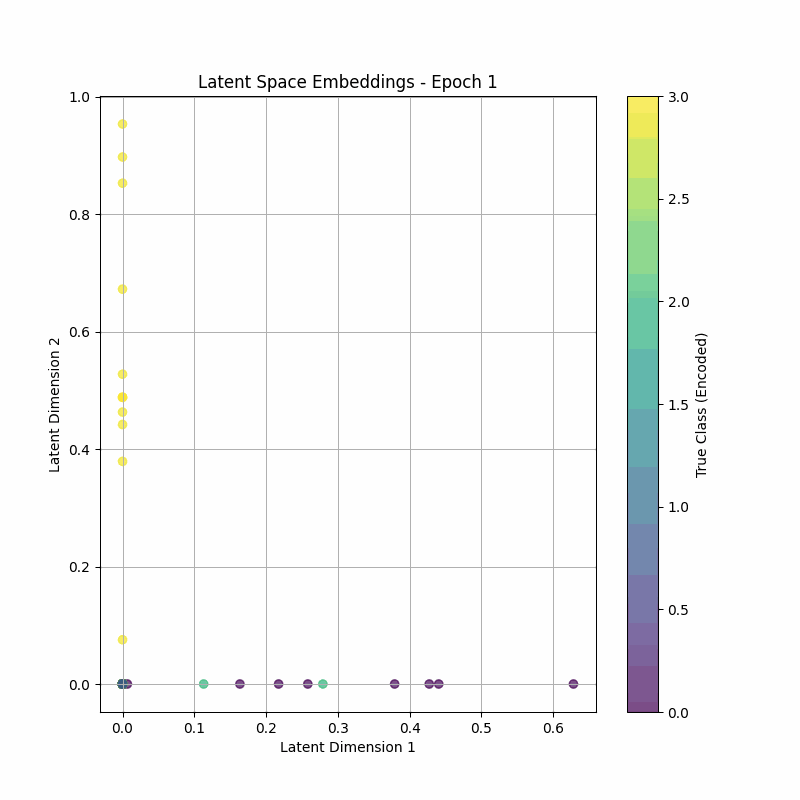

In [16]:
from IPython.display import Image
Image(url='latent_space_evolution.gif')
print(f"GIF saved: {gif_path}")
display(Image(filename=gif_path))

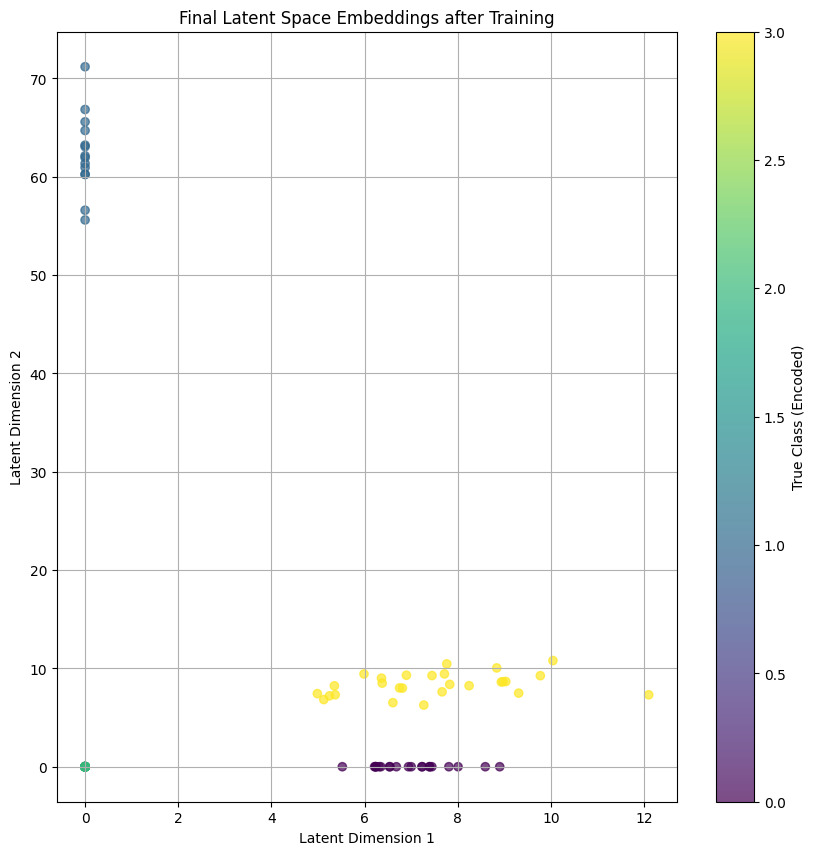

In [17]:
latent_model = tf.keras.Model(inputs=model.layers[0].input, outputs=model.get_layer('latent').output)
final_latent_embeddings = latent_model.predict(X_scaled, verbose=0)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(final_latent_embeddings[:, 0],
                      final_latent_embeddings[:, 1],
                      c=y_encoded,
                      cmap='viridis',
                      alpha=0.7)
plt.title('Final Latent Space Embeddings after Training')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.colorbar(scatter, label='True Class (Encoded)')
plt.grid(True)
plt.show()